[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mouryarahul/7CS107_PracticalWorks_Assignment/blob/master/Week9_Practical_Assignment_Part2.ipynb)


# Week 9 Practical Assignment Part-2 (Transfer Learning)

## Learning Objectives
By completing this assignment, you will: 
- Apply **Transfer Learning (Feature Extraction)** with **ResNet-18** for the **Hymenoptera (Bees vs Ants)** dataset.  
- Explore and report how **hyperparameters** affect performance.

> **Academic Honesty:** You may discuss ideas with peers; however, all code you submit must be your own. Cite any external resources you use.



## Environment & Requirements
- Python 3.8+
- Packages: `numpy`, `matplotlib`, `torch`, `torchvision`, `tqdm`, `scikit-learn` (for evaluation)
- GPU is optional but recommended for Part 3.

> If you are running on university machines or Colab, ensure the above libraries are available. For local runs, install via `pip install -U numpy matplotlib torch torchvision tqdm scikit-learn`.



---
# Task 3 — Transfer Learning (Feature Extraction) with ResNet-18 on Hymenoptera (Bees vs Ants) (60 Marks)

In this section, you will implement **feature extraction** using **ResNet-18** pretrained on ImageNet to classify images of **bees** and **ants**.

**What you will do:**
1. Load the Hymenoptera dataset (bees vs ants).  
2. Define data transforms (augmentation for train, standardization for val/test).  
3. Load `resnet18(pretrained=True)`, **freeze** all backbone parameters, and **replace the final FC layer** with a 2-class classifier.  
4. Train only the classifier head.  
5. Experiment with **hyperparameters** (LR, weight decay, optimizer, batch size, augmentation) and report accuracy and confusion matrix.

> **Dataset**: Nanually place the extracted folder `hymenoptera_data/` under `./data/` with subfolders `train/ants`, `train/bees`, `val/ants`, `val/bees`.

**On Google Colab, please chose a Nividia GPU in the Runtime environment. This is make the training faster.**


In [1]:

# Import necessary libraries
import os, time, copy
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, utils
from torchvision.transforms import v2
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
from typing import Dict

# For reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Check for available GPU devices otherwise use CPU
if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    DEVICE = torch.device('cuda')
    torch.cuda.manual_seed_all(SEED)
elif torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print('Using device:', DEVICE)


c:\Users\Rahul\miniconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda



## 3.1 Load Hymenoptera Dataset
This cell attempts to **download** the dataset from the PyTorch tutorial mirror. If download is not available, it will expect the folder structure:
```
./data/hymenoptera_data/
  ├── train/
  │   ├── ants/
  │   └── bees/
  └── val/
      ├── ants/
      └── bees/
```


In [2]:

# Dataset paths
data_root = os.path.join('data', 'hymenoptera_data')
train_dir = os.path.join(data_root, 'train')
val_dir   = os.path.join(data_root, 'val')


BATCH_SIZE = 16
NUM_WORKERS = 2 if os.name != 'nt' else 0
IMG_SIZE = 224
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

# Define transforms for Training Data: this is doing data augmentation and normalization
train_tfms = v2.Compose([
    v2.RandomResizedCrop(IMG_SIZE),
    v2.RandomHorizontalFlip(),
    #v2.ToTensor(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])
# Define transforms for Validation Data: only resizing and normalization
val_tfms = v2.Compose([
    v2.Resize(256),
    v2.CenterCrop(IMG_SIZE),
    # v2.ToTensor(),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean, std)
])

# Check if dataset exists
if not os.path.isdir(train_dir) or not os.path.isdir(val_dir):
    print('⚠️  Dataset not found at', data_root)
    print('Please place the hymenoptera_data folder under ./data/ as documented above.')

# Build datasets and loaders
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_dir,   transform=val_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=NUM_WORKERS)

class_names = train_ds.classes
print('Classes:', class_names)
print('Train images:', len(train_ds), '| Val images:', len(val_ds))

Classes: ['ants', 'bees']
Train images: 244 | Val images: 153



## 3.2 Visualize a Few Training Images


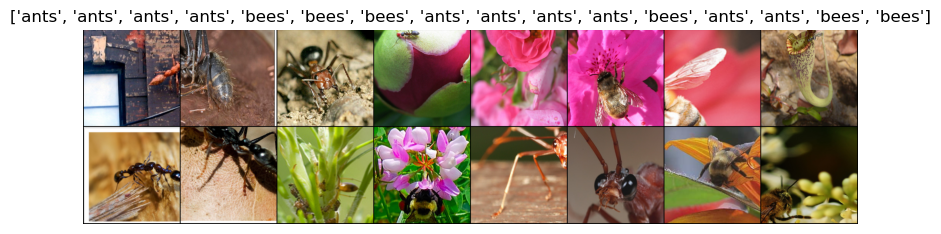

In [3]:

# Visualize a grid of images
inv_norm = v2.Normalize(
    mean=[-m/s for m, s in zip(mean,std)],
    std=[1/s for s in std]
)

def imshow_grid(inputs, title=None, nrow=8):
    inp = inputs.detach().cpu()
    # Undo normalization for visualization
    for i in range(inp.size(0)):
        inp[i] = inv_norm(inp[i])
    grid = torch.clamp(utils.make_grid(inp, nrow=nrow), 0, 1)
    plt.figure(figsize=(10, 5))
    plt.axis('off')
    if title is not None:
        plt.title(title)
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.show()

# Fetch a batch
images, labels = next(iter(train_loader))
imshow_grid(images[:16], title=[class_names[l] for l in labels[:16]], nrow=8)



## 3.3 Build ResNet-18 (Feature Extraction)
- Load `resnet18(pretrained=True)`
- **Freeze** all backbone layers
- Replace the final fully-connected layer with `nn.Linear(in_features, 2)`


In [ ]:
# Set environment variable for model download location
%env TORCH_HOME='pretrained_models'

# TODO: Get pretrained model: Build feature-extraction model
model = ... # Your code here

#TODO: Freeze backbone pretrained weights
#Your code here

#TODO: Replace final FC of the pretrained model with a new layer for 2 classes output
# If you want you can add one more FC layer
#Your code here

# Send model to the DEVICE
model = model.to(DEVICE)
print(model.fc)

env: TORCH_HOME='pretrained_models'
Linear(in_features=512, out_features=2, bias=True)



## 3.4 Define Loss, Optimizer, and Scheduler
- Use `CrossEntropyLoss`
- Choose an optimizer for **only the classifier head parameters** (e.g., SGD/Adam)
- Optionally, use a learning-rate scheduler such as `StepLR`


In [ ]:

# TODO: Hyperparameters (feel free to tune)
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 15
OPTIMIZER = 'adam'  # 'sgd' or 'adam'

# Define Loss function, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()

# Only params of final layer are being optimized
params_to_update = [p for p in model.parameters() if p.requires_grad]

if OPTIMIZER.lower() == 'sgd':
    optimizer = optim.SGD(params_to_update, lr=LR, momentum=0.9, weight_decay=WEIGHT_DECAY)
else:
    optimizer = optim.Adam(params_to_update, lr=LR, weight_decay=WEIGHT_DECAY)

# Define a learning rate scheduler (you can fine-tune the parameters like step_size and gamma)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)



## 3.5 Training & Evaluation Utilities


In [ ]:
#TODO: Write main training and validation loop
def train_model(model, criterion, optimizer, scheduler, num_epochs=EPOCHS):
    since = time.time()

    # Initialize history dictionary to record losses and accuracies
    history = {k: [] for k in ['train_loss','train_acc','val_loss','val_acc']}
    # Initialize best model weights and best accuracy
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Loop over epochs
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #TODO: Set model to training mode and dataloader to train_loader
                #Your code here
                dataloader = ... #Your code here
            else:
                #TODO: Set model to evaluation mode and dataloader to val_loader
                #Your code here
                dataloader = ... #Your code here

            # Initialize running loss and corrects for the epoch
            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloader, desc=phase):
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                # TODO: zero the parameter gradients
                # Your code here

                # TODO: perform forward and track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = ... # Your code here
                    _, preds = ... # Your code here
                    loss = ... # Your code here

                    # TODO: perform backward + optimize only if in training phase
                    if phase == 'train':
                        ... # Your code goes here
                        ... # Your code goes here

                # Record the statistics over the batch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Step the scheduler if in training phase
            if phase == 'train':
                scheduler.step()

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.float() / len(dataloader.dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

### Helper Functions to Plot Loss and Accuracy history over epoces

In [ ]:
def plot_curves(history: Dict[str, list]):
    '''Plot training and validation loss and accuracy curves.'''
    epochs = range(1, len(history['train_loss'])+1)
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], label='Train')
    plt.plot(epochs, history['val_loss'], label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss'); plt.legend();
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], label='Train')
    plt.plot(epochs, history['val_acc'], label='Val')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy'); plt.legend();
    plt.show()


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    '''This function prints and plots the confusion matrix.'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Epoch 1/15
----------


train: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]


train Loss: 0.7049 Acc: 0.5369


val: 100%|██████████| 10/10 [00:00<00:00, 12.90it/s]


val Loss: 0.5294 Acc: 0.7647
Epoch 2/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.40it/s]


train Loss: 0.4682 Acc: 0.8197


val: 100%|██████████| 10/10 [00:00<00:00, 17.77it/s]


val Loss: 0.3795 Acc: 0.8758
Epoch 3/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 20.13it/s]


train Loss: 0.4052 Acc: 0.8361


val: 100%|██████████| 10/10 [00:00<00:00, 16.35it/s]


val Loss: 0.3133 Acc: 0.9085
Epoch 4/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 18.36it/s]


train Loss: 0.3804 Acc: 0.8484


val: 100%|██████████| 10/10 [00:00<00:00, 16.61it/s]


val Loss: 0.2713 Acc: 0.9150
Epoch 5/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.63it/s]


train Loss: 0.3000 Acc: 0.8934


val: 100%|██████████| 10/10 [00:00<00:00, 17.44it/s]


val Loss: 0.2426 Acc: 0.9412
Epoch 6/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.98it/s]


train Loss: 0.3134 Acc: 0.8689


val: 100%|██████████| 10/10 [00:00<00:00, 17.37it/s]


val Loss: 0.2338 Acc: 0.9412
Epoch 7/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.53it/s]


train Loss: 0.2566 Acc: 0.9098


val: 100%|██████████| 10/10 [00:00<00:00, 17.62it/s]


val Loss: 0.2182 Acc: 0.9412
Epoch 8/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.60it/s]


train Loss: 0.2659 Acc: 0.8893


val: 100%|██████████| 10/10 [00:00<00:00, 17.12it/s]


val Loss: 0.2195 Acc: 0.9346
Epoch 9/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.70it/s]


train Loss: 0.2562 Acc: 0.9139


val: 100%|██████████| 10/10 [00:00<00:00, 17.53it/s]


val Loss: 0.2110 Acc: 0.9477
Epoch 10/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.21it/s]


train Loss: 0.2570 Acc: 0.9016


val: 100%|██████████| 10/10 [00:00<00:00, 16.75it/s]


val Loss: 0.2126 Acc: 0.9477
Epoch 11/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 20.06it/s]


train Loss: 0.2484 Acc: 0.9098


val: 100%|██████████| 10/10 [00:00<00:00, 16.97it/s]


val Loss: 0.2053 Acc: 0.9542
Epoch 12/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.63it/s]


train Loss: 0.2559 Acc: 0.8934


val: 100%|██████████| 10/10 [00:00<00:00, 17.48it/s]


val Loss: 0.2039 Acc: 0.9477
Epoch 13/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.68it/s]


train Loss: 0.2334 Acc: 0.9016


val: 100%|██████████| 10/10 [00:00<00:00, 17.35it/s]


val Loss: 0.2051 Acc: 0.9477
Epoch 14/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.66it/s]


train Loss: 0.2633 Acc: 0.8975


val: 100%|██████████| 10/10 [00:00<00:00, 17.39it/s]


val Loss: 0.2044 Acc: 0.9412
Epoch 15/15
----------


train: 100%|██████████| 16/16 [00:00<00:00, 19.83it/s]


train Loss: 0.2880 Acc: 0.8811


val: 100%|██████████| 10/10 [00:00<00:00, 16.93it/s]


val Loss: 0.2155 Acc: 0.9412
Training complete in 0m 25s
Best val Acc: 0.954248


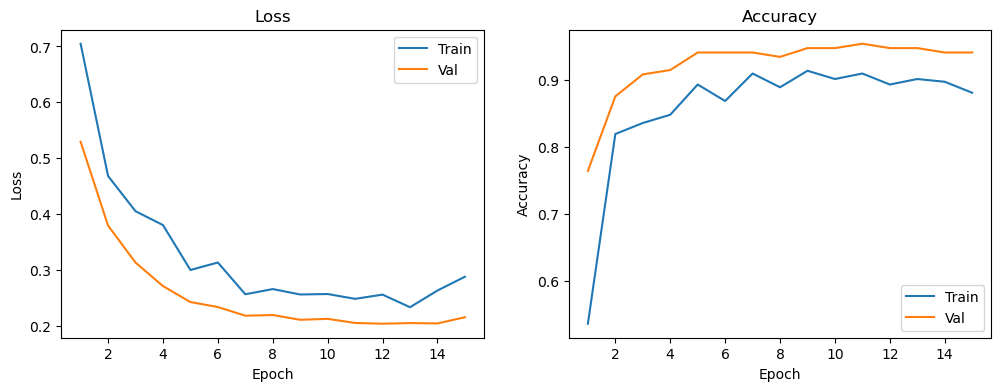

Evaluating: 100%|██████████| 10/10 [00:00<00:00, 17.03it/s]


              precision    recall  f1-score   support

        ants       0.93      0.97      0.95        70
        bees       0.97      0.94      0.96        83

    accuracy                           0.95       153
   macro avg       0.95      0.96      0.95       153
weighted avg       0.96      0.95      0.95       153



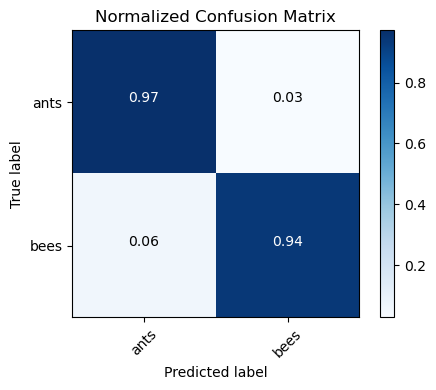

In [ ]:
#TODO: Fine-tune the pretrained model using the train_model function
final_model, history = ... # Your code here

# Save the trained model
os.makedirs('trained_model', exist_ok=True)
torch.save(final_model.state_dict(), 'trained_model/hymenoptera_resnet18_finetuned.pth')

# Plot training curves
plot_curves(history)

#TODO: Evaluate the Fine-tuned model on validation set
final_model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc='Evaluating'):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        outputs = ... # Your code here
        _, preds = ... # Your code here
        all_preds.extend(preds.cpu().numpy()) # Convert the preds tensor to numpy
        all_labels.extend(labels.cpu().numpy()) # Convert the labels tensor to numpy

# Plot Confusion Matrix and Classification Report
final_accuracy = accuracy_score(all_labels, all_preds) # Calculate the final accuracy
print(f'Final Accuracy: {final_accuracy:.4f}')
cm = confusion_matrix(all_labels, all_preds)
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
print(classification_report(all_labels, all_preds, target_names=class_names))